In [1]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import confirm.mini_imprint as ip

In [2]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, *, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = ip.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

## Calculate Type I Error

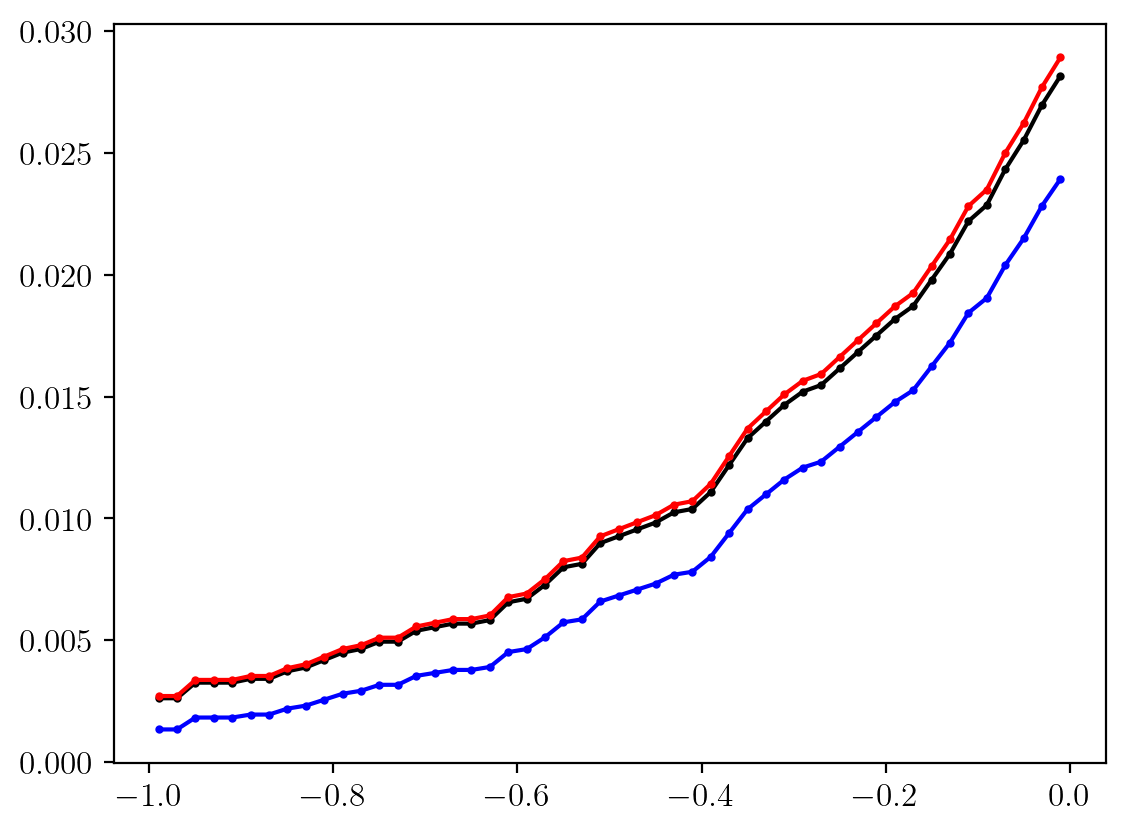

In [4]:
g = ip.cartesian_grid([-1], [1], n=[100], null_hypos=[ip.hypo("x < 0")])
# lam = -1.96 because we negated the statistics so we can do a less thanj
# comparison.
rej_df = ip.validate(ZTest1D, g, -1.96, K=8192)

plt.plot(g.df["theta0"], rej_df["TI_sum"] / rej_df["K"], "b-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_cp_bound"], "k-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_bound"], "r-o", markersize=2)
plt.show()

## Adagrid Tuning

In [146]:
g = ip.cartesian_grid(theta_min=[-1], theta_max=[1], null_hypos=[ip.hypo("x0 < 0")])
ada, reports = ip.ada_tune(ZTest1D, g, nB=5)

IndexError: tuple index out of range

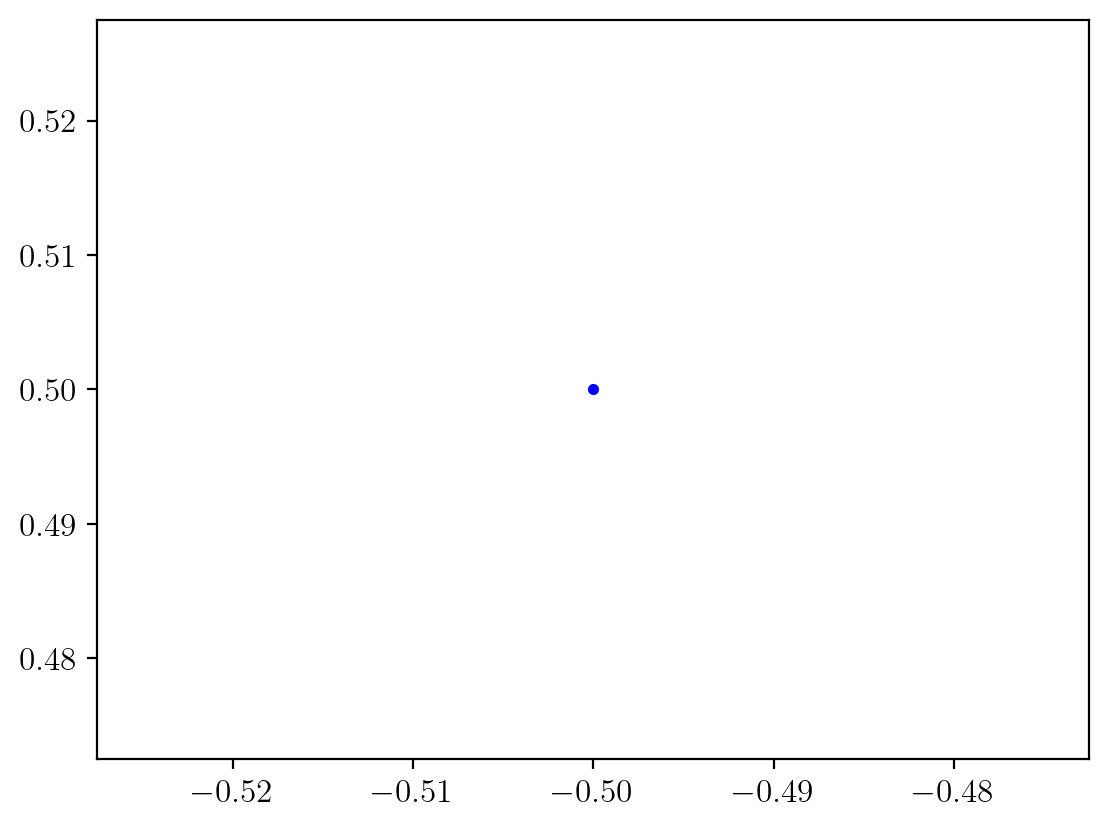

In [138]:
# g = grid.Grid(ada.tiledb.get_all())
ga = g.subset(g.df["active"])
plt.plot(ga.get_theta()[:, 0], ga.get_radii()[:, 0], "bo", markersize=3)
plt.show()

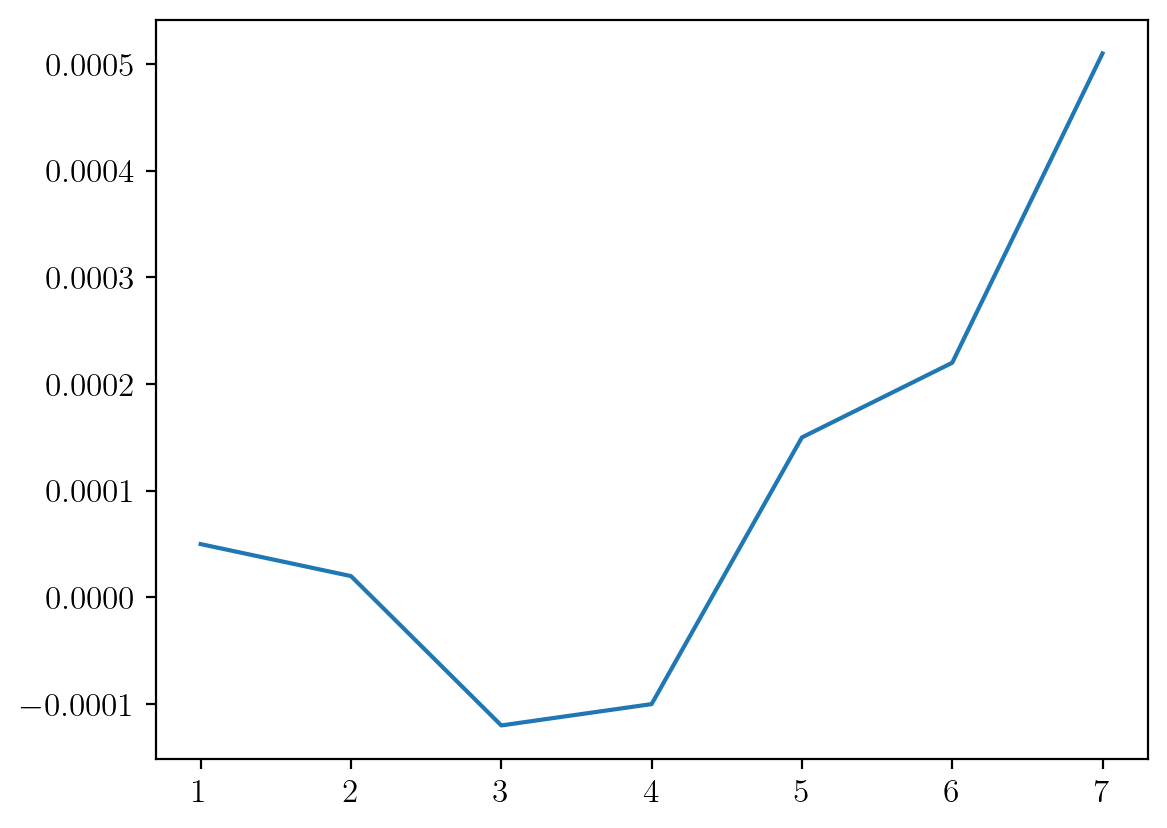

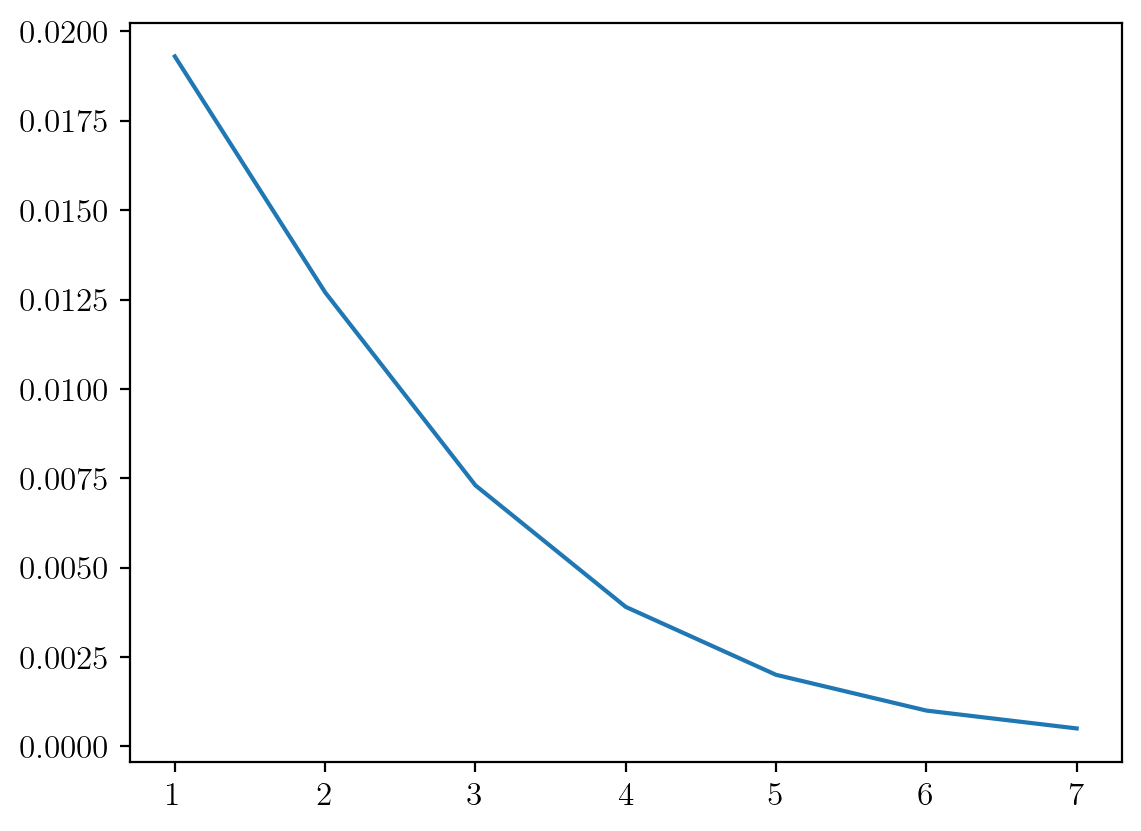

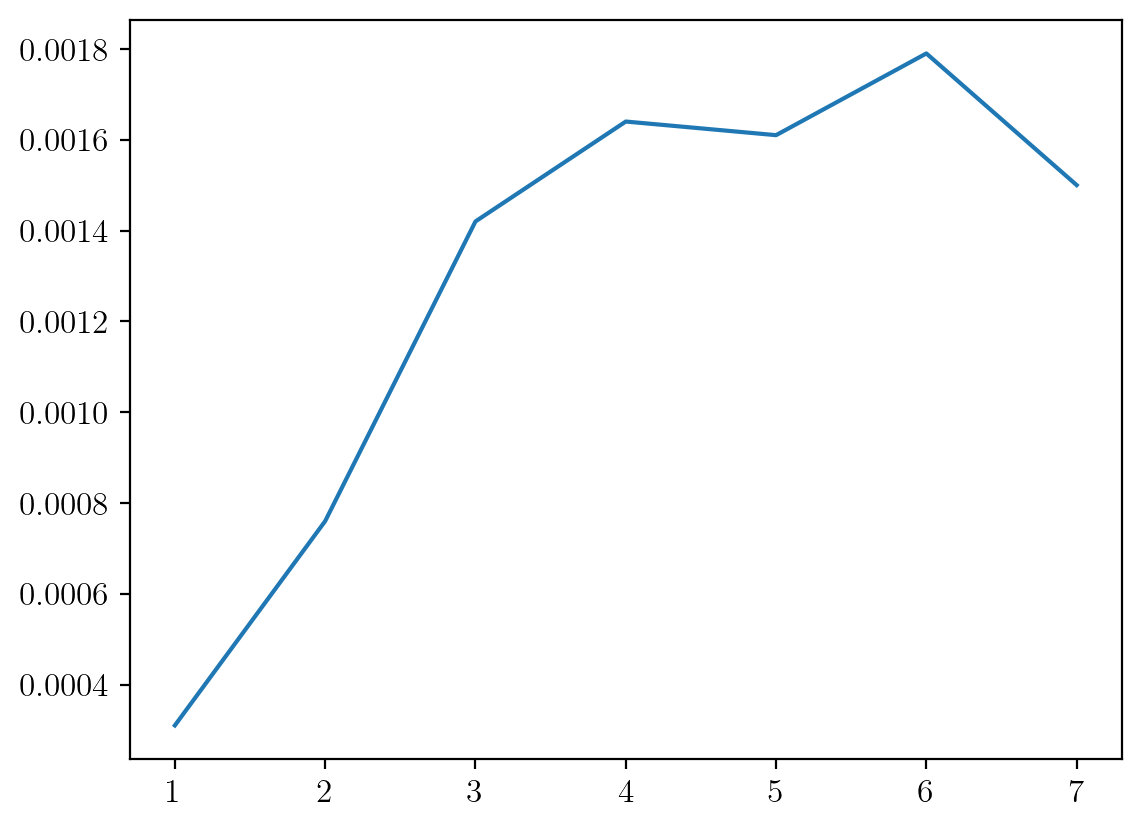

In [139]:
evolution = pd.DataFrame(reports)
plt.plot(evolution["i"], evolution["bias"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["grid_cost"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["std_tie"].astype(float))
plt.show()

In [140]:
all = ada.tiledb.get_all()
all = all.loc[all["active"]]
all.nsmallest(10, "orderer")

,K,theta0,radii0,parent_id,birthday,active,locked,eligible,id,null_truth0,alpha0,grid_cost,impossible,orderer,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_min_lams,twb_mean_lams,twb_max_lams
36,16384,-0.007812,0.007812,10221554597160288257,7,True,False,True,10221554614340157440,True,0.024474,0.000526,False,-1.957964,-1.953787,-1.956655,-1.955141,-1.943583,-1.906378,-1.965992,-1.933890,-1.957964,-1.944383,-1.943583,-1.927134,-1.957964,-1.941391,-1.927134
37,16384,-0.023438,0.007812,10221554597160288256,7,True,False,True,10221554614340157441,True,0.024474,0.000526,False,-1.942339,-1.938162,-1.941030,-1.939516,-1.927958,-1.890753,-1.950367,-1.918265,-1.942339,-1.928758,-1.927958,-1.911509,-1.942339,-1.925766,-1.911509
38,32768,-0.046875,0.015625,10221554579980419072,7,True,False,True,10221554614340157442,True,0.023958,0.001042,False,-1.935442,-1.927784,-1.929323,-1.938452,-1.922502,-1.940581,-1.927259,-1.901062,-1.935442,-1.920815,-1.927259,-1.909221,-1.935442,-1.918760,-1.901062
39,65536,-0.093750,0.031250,10221554579980419073,7,True,False,True,10221554614340157443,True,0.022954,0.002046,False,-1.910470,-1.897489,-1.879322,-1.910470,-1.897900,-1.905049,-1.909180,-1.884643,-1.892130,-1.887694,-1.910470,-1.906792,-1.910470,-1.896346,-1.884643
40,131072,-0.187500,0.062500,10221554579980419074,7,True,False,True,10221554614340157444,True,0.021055,0.003945,False,-1.857406,-1.847388,-1.855783,-1.845307,-1.848073,-1.841339,-1.855783,-1.844355,-1.843116,-1.843116,-1.857406,-1.832329,-1.857406,-1.844064,-1.832329
31,131072,-0.312500,0.062500,10221554579980419075,7,True,False,True,10221554631520026625,True,0.021055,0.003945,False,-1.732406,-1.722388,-1.730783,-1.720307,-1.723073,-1.716339,-1.730783,-1.719355,-1.718116,-1.718116,-1.732406,-1.707329,-1.732406,-1.719064,-1.707329
30,131072,-0.437500,0.062500,10221554579980419075,7,True,False,True,10221554631520026624,True,0.021055,0.003945,False,-1.607406,-1.597388,-1.605783,-1.595307,-1.598073,-1.591339,-1.605783,-1.594355,-1.593116,-1.593116,-1.607406,-1.582329,-1.607406,-1.594064,-1.582329
33,131072,-0.562500,0.062500,10221554597160288259,7,True,False,True,10221554631520026627,True,0.021055,0.003945,False,-1.482406,-1.472388,-1.480783,-1.470307,-1.473073,-1.466339,-1.480783,-1.469355,-1.468116,-1.468116,-1.482406,-1.457329,-1.482406,-1.469064,-1.457329
32,131072,-0.687500,0.062500,10221554597160288259,7,True,False,True,10221554631520026626,True,0.021055,0.003945,False,-1.357406,-1.347388,-1.355783,-1.345307,-1.348073,-1.341339,-1.355783,-1.344355,-1.343116,-1.343116,-1.357406,-1.332329,-1.357406,-1.344064,-1.332329
35,131072,-0.812500,0.062500,10221554597160288258,7,True,False,True,10221554631520026629,True,0.021055,0.003945,False,-1.232406,-1.222388,-1.230783,-1.220307,-1.223073,-1.216339,-1.230783,-1.219355,-1.218116,-1.218116,-1.232406,-1.207329,-1.232406,-1.219064,-1.207329


In [141]:
import scipy.stats

lamss = all["lams"].min()
true_err = 1 - scipy.stats.norm.cdf(-lamss)
lamss, true_err

(-1.9537866115570068, 0.02536322914037914)

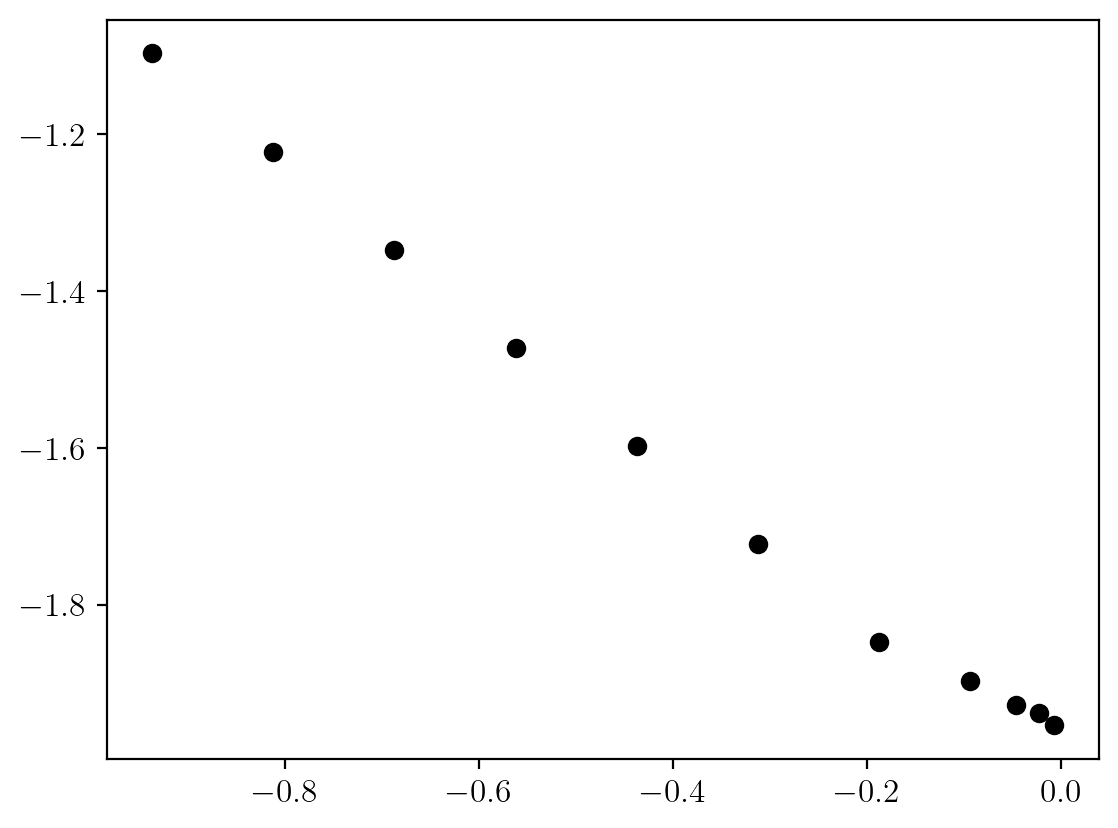

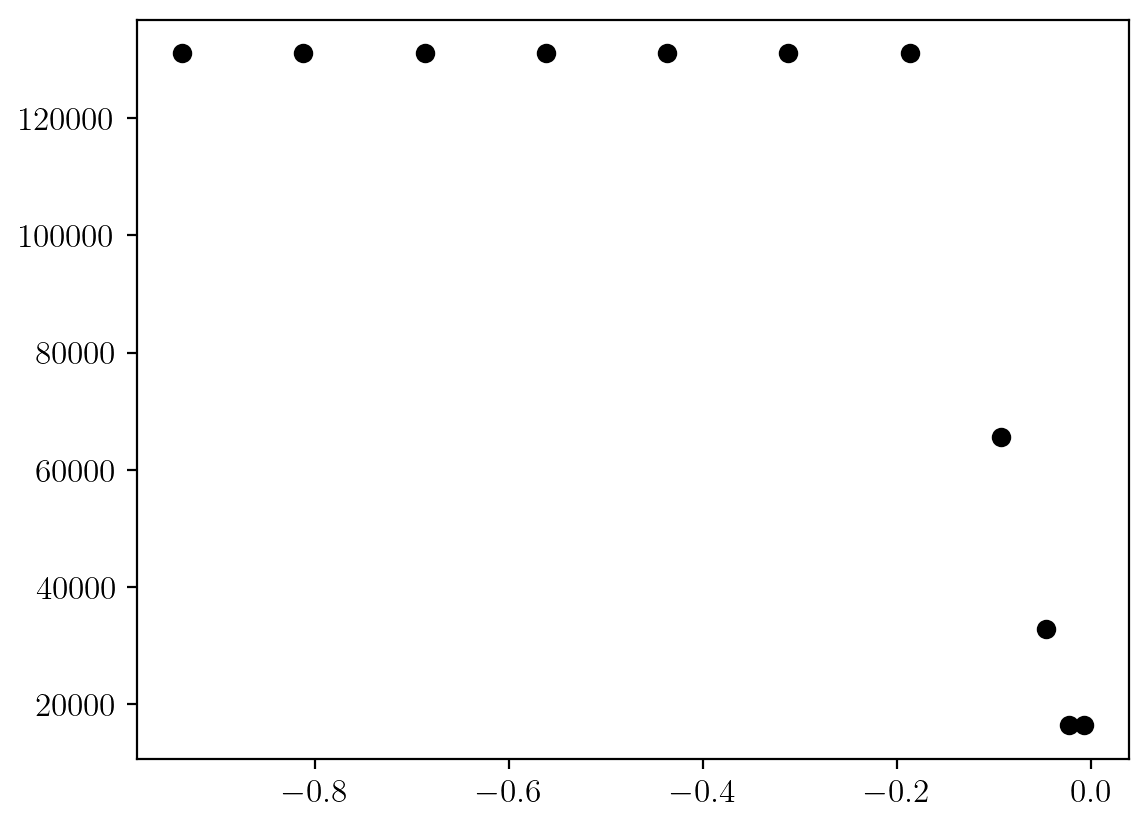

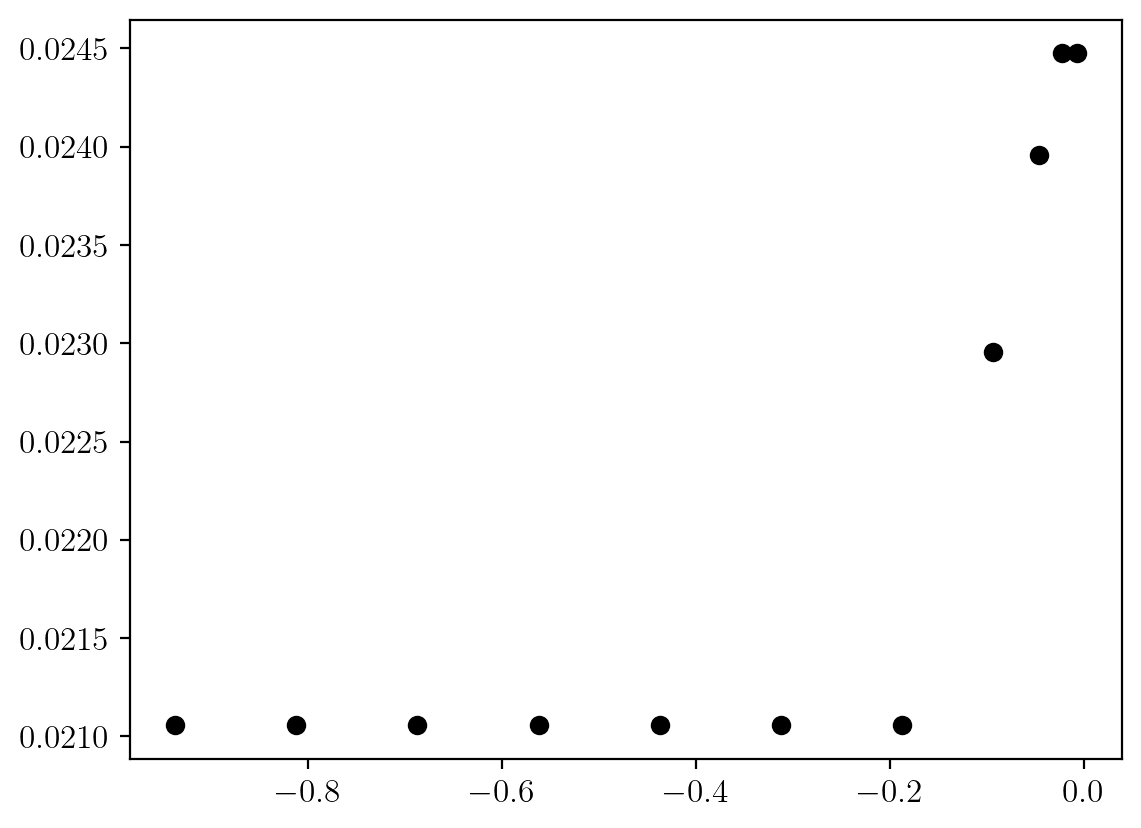

In [142]:
plt.plot(all["theta0"], all["lams"], "ko")
plt.show()
plt.plot(all["theta0"], all["K"], "ko")
plt.show()
plt.plot(all["theta0"], all["alpha0"], "ko")
plt.show()